In [ ]:
# MNIST image generation using DCGAN
import torch
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio

In [ ]:
# Parameters
image_size = 64
G_input_dim = 100
G_output_dim = 1
D_input_dim = 1
D_output_dim = 1
num_filters = [1024, 512, 256, 128]
learning_rate = 0.0002
betas = (0.5, 0.999)
batch_size = 128
num_epochs = 20
data_dir = '../Data/MNIST_data/'
save_dir = 'MNIST_DCGAN_results/'

In [ ]:
# MNIST dataset
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

mnist_data = dsets.MNIST(root=data_dir,
                         train=True,
                         transform=transform,
                         download=True)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=batch_size,
                                          shuffle=True)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.6MB/s]


Extracting ../Data/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ../Data/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 339kB/s]


Extracting ../Data/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ../Data/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.75MB/s]


Extracting ../Data/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../Data/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.34MB/s]

Extracting ../Data/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../Data/MNIST_data/MNIST/raw



In [ ]:
# De-normalization
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

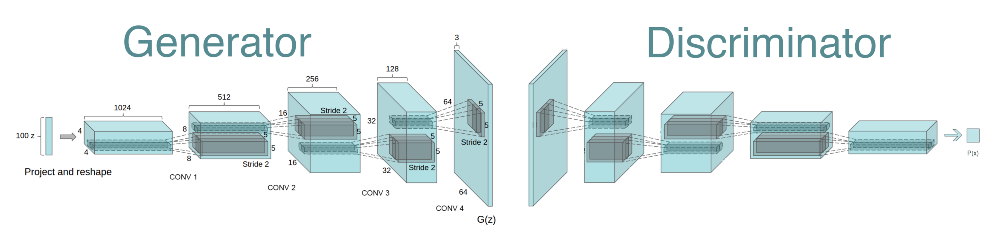

In [ ]:

# Generator model
class Generator(torch.nn.Module):
    def __init__(self, input_dim, num_filters, output_dim):
        super(Generator, self).__init__()
        #num_filters = [1024, 512, 256, 128]
        # Hidden layers
        self.hidden_layer = torch.nn.Sequential()
        for i in range(len(num_filters)):
            # Deconvolutional layer
            if i == 0:
                deconv = torch.nn.ConvTranspose2d(input_dim, num_filters[i], kernel_size=4, stride=1, padding=0)
            else:
                deconv = torch.nn.ConvTranspose2d(num_filters[i-1], num_filters[i], kernel_size=4, stride=2, padding=1)

            deconv_name = 'deconv' + str(i + 1)
            self.hidden_layer.add_module(deconv_name, deconv)

            # Initializer
            torch.nn.init.normal(deconv.weight, mean=0.0, std=0.02)
            torch.nn.init.constant(deconv.bias, 0.0)

            # Batch normalization
            bn_name = 'bn' + str(i + 1)
            self.hidden_layer.add_module(bn_name, torch.nn.BatchNorm2d(num_filters[i]))

            # Activation
            act_name = 'act' + str(i + 1)
            self.hidden_layer.add_module(act_name, torch.nn.ReLU())

        # Output layer
        self.output_layer = torch.nn.Sequential()
        # Deconvolutional layer
        out = torch.nn.ConvTranspose2d(num_filters[i], output_dim, kernel_size=4, stride=2, padding=1)
        self.output_layer.add_module('out', out)
        # Initializer
        torch.nn.init.normal(out.weight, mean=0.0, std=0.02)
        torch.nn.init.constant(out.bias, 0.0)
        # Activation
        self.output_layer.add_module('act', torch.nn.Tanh())

    def forward(self, x):
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        return out


# Discriminator model
class Discriminator(torch.nn.Module):
    def __init__(self, input_dim, num_filters, output_dim):
        super(Discriminator, self).__init__()
        # num_filters = [1024, 512, 256, 128]
        # Hidden layers
        self.hidden_layer = torch.nn.Sequential()
        for i in range(len(num_filters)):
            # Convolutional layer
            if i == 0:
                conv = torch.nn.Conv2d(input_dim, num_filters[i], kernel_size=4, stride=2, padding=1)
            else:
                conv = torch.nn.Conv2d(num_filters[i-1], num_filters[i], kernel_size=4, stride=2, padding=1)

            conv_name = 'conv' + str(i + 1)
            self.hidden_layer.add_module(conv_name, conv)

            # Initializer
            torch.nn.init.normal(conv.weight, mean=0.0, std=0.02)
            torch.nn.init.constant(conv.bias, 0.0)

            # Batch normalization
            if i != 0:
                bn_name = 'bn' + str(i + 1)
                self.hidden_layer.add_module(bn_name, torch.nn.BatchNorm2d(num_filters[i]))

            # Activation
            act_name = 'act' + str(i + 1)
            self.hidden_layer.add_module(act_name, torch.nn.LeakyReLU(0.2))

        # Output layer
        self.output_layer = torch.nn.Sequential()
        # Convolutional layer
        out = torch.nn.Conv2d(num_filters[i], output_dim, kernel_size=4, stride=1, padding=0)
        self.output_layer.add_module('out', out)
        # Initializer
        torch.nn.init.normal(out.weight, mean=0.0, std=0.02)
        torch.nn.init.constant(out.bias, 0.0)
        # Activation
        self.output_layer.add_module('act', torch.nn.Sigmoid())

    def forward(self, x):
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        return out


In [ ]:
# Plot losses
def plot_loss(d_losses, g_losses, num_epoch, save=False, save_dir='MNIST_DCGAN_results/', show=False):
    fig, ax = plt.subplots()
    ax.set_xlim(0, num_epochs)
    ax.set_ylim(0, max(np.max(g_losses), np.max(d_losses))*1.1)
    plt.xlabel('Epoch {0}'.format(num_epoch + 1))
    plt.ylabel('Loss values')
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.legend()

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_fn = save_dir + 'MNIST_DCGAN_losses_epoch_{:d}'.format(num_epoch + 1) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()


In [ ]:
# Models
G = Generator(G_input_dim, num_filters, G_output_dim)
D = Discriminator(D_input_dim, num_filters[::-1], D_output_dim)
#G.cuda()
#D.cuda()
G
D

# Loss function
criterion = torch.nn.BCELoss()

# Optimizers
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas=betas)
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas=betas)

# Training GAN
D_avg_losses = []
G_avg_losses = []

# Fixed noise for test
num_test_samples = 5*5
fixed_noise = torch.randn(num_test_samples, G_input_dim).view(-1, G_input_dim, 1, 1)

for epoch in range(num_epochs):
    D_losses = []
    G_losses = []

    # minibatch training
    for i, (images, _) in enumerate(data_loader):

        # image data
        mini_batch = images.size()[0]
        #x_ = Variable(images.cuda())
        x_ = Variable(images)

        # labels
        #y_real_ = Variable(torch.ones(mini_batch).cuda())
        #y_fake_ = Variable(torch.zeros(mini_batch).cuda())
        y_real_ = Variable(torch.ones(mini_batch)) # Label  1 Real
        y_fake_ = Variable(torch.zeros(mini_batch)) # Label 0 Fake

        # Train discriminator with real data
        D_real_decision = D(x_).squeeze()
        # print(D_real_decision, y_real_)
        D_real_loss = criterion(D_real_decision, y_real_)

        # Train discriminator with fake data
        z_ = torch.randn(mini_batch, G_input_dim).view(-1, G_input_dim, 1, 1)
        #z_ = Variable(z_.cuda())
        z_ = Variable(z_)
        gen_image = G(z_)

        D_fake_decision = D(gen_image).squeeze()
        D_fake_loss = criterion(D_fake_decision, y_fake_)

        # Back propagation
        D_loss = D_real_loss + D_fake_loss
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Train generator
        z_ = torch.randn(mini_batch, G_input_dim).view(-1, G_input_dim, 1, 1)
        #z_ = Variable(z_.cuda())
        z_ = Variable(z_)
        gen_image = G(z_)

        D_fake_decision = D(gen_image).squeeze()
        G_loss = criterion(D_fake_decision, y_real_)

        # Back propagation
        D.zero_grad()
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # loss values
        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

        print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
              % (epoch+1, num_epochs, i+1, len(data_loader), D_loss.item(), G_loss.item()))

    D_avg_loss = torch.mean(torch.FloatTensor(D_losses))
    G_avg_loss = torch.mean(torch.FloatTensor(G_losses))

    # avg loss values for plot
    D_avg_losses.append(D_avg_loss)
    G_avg_losses.append(G_avg_loss)

    plot_loss(D_avg_losses, G_avg_losses, epoch, save=True)

    # Show result for fixed noise
    plot_result(G, fixed_noise, epoch, save=True, fig_size=(5, 5))

# Make gif
loss_plots = []
gen_image_plots = []
for epoch in range(num_epochs):
    # plot for generating gif
    save_fn1 = save_dir + 'MNIST_DCGAN_losses_epoch_{:d}'.format(epoch + 1) + '.png'
    loss_plots.append(imageio.imread(save_fn1))

    save_fn2 = save_dir + 'MNIST_DCGAN_epoch_{:d}'.format(epoch + 1) + '.png'
    gen_image_plots.append(imageio.imread(save_fn2))

imageio.mimsave(save_dir + 'MNIST_DCGAN_losses_epochs_{:d}'.format(num_epochs) + '.gif', loss_plots, fps=5)
imageio.mimsave(save_dir + 'MNIST_DCGAN_epochs_{:d}'.format(num_epochs) + '.gif', gen_image_plots, fps=5)

<ipython-input-5-75f590fec824>:19: FutureWarning: `nn.init.normal` is now deprecated in favor of `nn.init.normal_`.
  torch.nn.init.normal(deconv.weight, mean=0.0, std=0.02)
<ipython-input-5-75f590fec824>:20: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  torch.nn.init.constant(deconv.bias, 0.0)
<ipython-input-5-75f590fec824>:36: FutureWarning: `nn.init.normal` is now deprecated in favor of `nn.init.normal_`.
  torch.nn.init.normal(out.weight, mean=0.0, std=0.02)
<ipython-input-5-75f590fec824>:37: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  torch.nn.init.constant(out.bias, 0.0)
<ipython-input-5-75f590fec824>:65: FutureWarning: `nn.init.normal` is now deprecated in favor of `nn.init.normal_`.
  torch.nn.init.normal(conv.weight, mean=0.0, std=0.02)
<ipython-input-5-75f590fec824>:66: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  torch.nn.init.constant(conv.bias, 0.0)

Epoch [1/20], Step [1/469], D_loss: 2.5704, G_loss: 1.8755
Epoch [1/20], Step [2/469], D_loss: 10.8079, G_loss: 6.2638
Epoch [1/20], Step [3/469], D_loss: 4.5883, G_loss: 16.9035
Epoch [1/20], Step [4/469], D_loss: 0.1609, G_loss: 14.2232
Epoch [1/20], Step [5/469], D_loss: 1.5805, G_loss: 21.1073
Epoch [1/20], Step [6/469], D_loss: 1.2197, G_loss: 15.8775
Epoch [1/20], Step [7/469], D_loss: 0.5453, G_loss: 20.3998
Epoch [1/20], Step [8/469], D_loss: 0.0549, G_loss: 15.9358
Epoch [1/20], Step [9/469], D_loss: 0.4643, G_loss: 21.6273
Epoch [1/20], Step [10/469], D_loss: 0.0337, G_loss: 17.3464
Epoch [1/20], Step [11/469], D_loss: 0.5553, G_loss: 29.4024
Epoch [1/20], Step [12/469], D_loss: 0.3608, G_loss: 31.6536
Epoch [1/20], Step [13/469], D_loss: 0.0947, G_loss: 29.5962
Epoch [1/20], Step [14/469], D_loss: 0.0084, G_loss: 19.1579
Epoch [1/20], Step [15/469], D_loss: 0.8820, G_loss: 42.5828
Epoch [1/20], Step [16/469], D_loss: 0.4494, G_loss: 52.2285
Epoch [1/20], Step [17/469], D_los